## NOTEBOOK on IBM Watson Studio shared via GitHub

This notebook will be used for Applied Data Science Capstone Project week 5 assignment

#### The assignment will be handled as follows:

* Information about EU capitals will be collected
* Within each capital within 2km radius around the center information about Coffee Shops will be collected (provided that Foursquare contains data about opening hours and rating for a specific Coffee Shop)
* List of Coffee shops chosen will be shortened by selected criteria to match certain rating and opening hours
* Some basic analysis will be done
* KMeans algorithm will cluster Coffee Shops
* Some visualisations will be done, coclusions drawn

Firstly, importing all the needed libraries.

In [1]:
import pandas as pd
import numpy as np
import requests
import urllib.request
from bs4 import BeautifulSoup
import lxml
import json
from datetime import date
import calendar

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  54.13 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  32.37 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  38.31 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.60 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |###################

### STEP 1: EU capital information

Retrieving information about EU capitals:

In [2]:
# Data will be retrieved from the given page
link_to_EU_capital_list='https://en.wikipedia.org/wiki/Member_state_of_the_European_Union'
# Request and sava data in 'page' object
page = requests.get(link_to_EU_capital_list)
# Use 'BeautifulSoup' tool to work with retrieved data
soup = BeautifulSoup(page.text, 'lxml')
# Creating an empty data frame to store the data 
df = pd.DataFrame()

In [3]:
# Finding the table in the page
match_table = soup.find('table', class_='wikitable sortable')

# Needed infrmation first will be collected in a list
List_Capital = []
List_Country = []

# The following cyclicly goes through each row of the table and collects information
i=1
for match_element in match_table.find_all('td'):
    if i==1: List_Country.append(match_element.text)
    if i==6: List_Capital.append(match_element.text)
    if i==18: i=0
    i=i+1

In [4]:
df['Country']=List_Country
df['Capital']=List_Capital

# Cleaning data
for index, element in df.iterrows():
    element['Country']=element['Country'].strip("\n")
    element['Capital']=element['Capital'].strip("\n")

# Cleaning data
for index, element in df.iterrows():
    element['Country']=element['Country'].strip("[k]") 
    
# Colums for Latitude and Longitude are created
df['Latitude']=''
df['Longitude']=''

Finding GPS coordinates for all EU capitals:

In [5]:
# In case geolocator times out
def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except: 
        return do_geocode(address)

In [6]:
Lat=[]
Lon=[]

i=1
for index, element in df.iterrows():
    
    if i<=len(df):
        address = element['Capital']
        geolocator = Nominatim(user_agent="my-application")
        location = do_geocode(address)
        Lat.append(location.latitude)
        Lon.append(location.longitude)
        i=i+1

df['Latitude']=pd.Series(Lat)
df['Longitude']=pd.Series(Lon)    

Checking the result of dataframe containing capitals with coordinates. (For the purpose of this exercise, we'll use 10 cities only, as an attempt to process all the capitals in the list result in Foursquare having too many data calls for the free-of-charge data we are planning to use)

In [7]:
df.head(10)

,Country,Capital,Latitude,Longitude
0,Austria,Vienna,48.208354,16.372504
1,Belgium,Brussels,50.846557,4.351697
2,Bulgaria,Sofia,42.697863,23.322179
3,Croatia,Zagreb,45.813177,15.977048
4,Cyprus,Nicosia,35.180282,33.373696
5,Czechia,Prague,50.087465,14.421254
6,Denmar,Copenhagen,55.686724,12.570072
7,Estonia,Tallinn,59.437216,24.745369
8,Finland,Helsinki,60.167409,24.942568
9,France,Paris,48.856610,2.351499


### STEP 2: Foursquare data

Getting Foursquare credentials:

In [8]:
CLIENT_ID = 'RS2GIZGV5OWNI5C3WMXWVY2HQU3BQFTZVEOCGILNT1WZHBQ0' # your Foursquare ID
CLIENT_SECRET = 'SMN3D2C3NHIEH55H4BCNNHLQ0BJUMQ52WETMSBF1JHFH4433' # your Foursquare Secret
VERSION = '20181010' # Foursquare API version
search_query = 'Coffee'# We are looking for Coffee
radius=2000
LIMIT=500

In [9]:
# Data frame for coffee shops
capital_coffee_shops_df = pd.DataFrame()

*The following function makes sures to delete all unnecesary columns from the retrieved dataset*

In [10]:
# Removing unneeded data
def delete_cols(X):

    if 'categories' in X.columns: X=X.drop(['categories'], axis=1)
    if 'hasPerk' in X.columns: X=X.drop(['hasPerk'], axis=1)
    if 'location.address' in X.columns: X=X.drop(['location.address'], axis=1)
    if 'location.city' in X.columns: X=X.drop(['location.city'], axis=1)
    if 'location.country' in X.columns: X=X.drop(['location.country'], axis=1)
    if 'location.crossStreet' in X.columns: X=X.drop(['location.crossStreet'], axis=1)
    if 'location.formattedAddress' in X.columns: X=X.drop(['location.formattedAddress'], axis=1)
    if 'location.labeledLatLngs' in X.columns: X=X.drop(['location.labeledLatLngs'], axis=1)
    if 'location.postalCode' in X.columns: X=X.drop(['location.postalCode'], axis=1)
    if 'location.state' in X.columns: X=X.drop(['location.state'], axis=1)
    if 'referralId' in X.columns: X=X.drop(['referralId'], axis=1)
    if 'location.cc' in X.columns: X=X.drop(['location.cc'], axis=1)
    if 'venuePage.id' in X.columns: X=X.drop(['venuePage.id'], axis=1)
    if 'location.neighborhood' in X.columns: X=X.drop(['location.neighborhood'], axis=1)
    
    return X

*The following function retrieves closing time from a given time string*

In [11]:
def actual_time(X):
    from_time=X.rfind('–')+1
    actual_closing_time=X[from_time:]
    return actual_closing_time

*The following function retrieves closing time per week day from the data format given by Foursquare. The challenge is that there are many different formats, so the function is long.*

In [12]:
def hours(X):
    
    list_of_closure=[]
    closure_day=[]

    week_day=calendar.day_name[date.today().weekday()][0:3]

    for index, element in X.iterrows():
        if element['days']=='Today': element['days']=week_day

    for index, element in X.iterrows():
        string=element['days']
    
        if ('Mon' in string):
            closure_day.append(1)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))

            if ('Tue' in string):
                closure_day.append(2)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
            
            elif ('Wed' in string):
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(2)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
            
            elif ('Thu' in string):
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(2)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
            elif ('Fri' in string):
                closure_day.append(5)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(2)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                    
        elif ('Tue' in string):
            closure_day.append(2)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))

            if ('Wed' in string):
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
            
            elif ('Thu' in string):
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                
            elif ('Fri' in string):
                closure_day.append(5)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(3)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
        elif ('Wed' in string):
            closure_day.append(3)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
            if ('Thu' in string):
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                    
            elif ('Fri' in string):
                closure_day.append(5)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
                closure_day.append(4)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
    
        elif ('Thu' in string):
            closure_day.append(4)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
            if ('Fri' in string):
                closure_day.append(5)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
        elif ('Fri' in string):
            closure_day.append(5)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
            if ('Sat' in string):
                closure_day.append(6)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
        elif ('Sat' in string):
            closure_day.append(6)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
            if ('Sun' in string):
                closure_day.append(7)
                list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
        
        elif ('Sun' in string):
            closure_day.append(7)
            list_of_closure.append(actual_time(element['open'][0]['renderedTime']))
    
    return [list_of_closure, closure_day]

*The following function assigns the closing time for a specific Coffee Shop - dataframe is updated.*

In [13]:
def hours_to_frame(Y, j, time, week_day):
    
    sorted_week=['xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx', 'xxx']

    i=0
    while (i<len(week_day)): 
        if (week_day[i]==1): sorted_week[0]=time[i]
        elif (week_day[i]==2): sorted_week[1]=time[i]
        elif (week_day[i]==3): sorted_week[2]=time[i]
        elif (week_day[i]==4): sorted_week[3]=time[i]
        elif (week_day[i]==5): sorted_week[4]=time[i]
        elif (week_day[i]==6): sorted_week[5]=time[i]
        elif (week_day[i]==7): sorted_week[6]=time[i]
        i=i+1
    
    Y.at[j,'Mon']=sorted_week[0]
    Y.at[j,'Tue']=sorted_week[1]
    Y.at[j,'Wed']=sorted_week[2]
    Y.at[j,'Thu']=sorted_week[3]
    Y.at[j,'Fri']=sorted_week[4]
    Y.at[j,'Sat']=sorted_week[5]
    Y.at[j,'Sun']=sorted_week[6]
        
    return

*The following function runs through all Coffee Shops in a given capital and retrieves Coffee Shop specific data.*

In [14]:
def coffee_shop_data(X):

    i=-1
    for index, element in X.iterrows():

        i=i+1
    
        if (i<len(X)):
            
            url2 = 'https://api.foursquare.com/v2/venues/' + X.loc[i, 'ID'] + '?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

            results2 = requests.get(url2).json()
        
            json_string = json.dumps(results2)

            if ('popular' in json_string) and ('rating' in json_string):
        
                foursquare_response2 = results2['response']['venue']['popular']['timeframes']
            
                results_flat2 = json_normalize(foursquare_response2) # flatten JSON
                    
                foursquare_response3 = results2['response']['venue']['rating'] # Returns float number
                X.at[i,'Rating']=foursquare_response3
            
                results_flat2=results_flat2.drop(['includesToday'], axis=1)
                results_flat2=results_flat2.drop(['segments'], axis=1)
                    
                values = hours(results_flat2)
            
                hours_to_frame(X, i, values[0], values[1])

    X=X.dropna(subset=['Mon', 'Tue', 'Wed', 'Thu', 'Sat', 'Sun'])
    X = X.reset_index(drop=True)
    
    return X

The following piece of code is the main part collecting dataframes with Coffee Shop data and stores within a dictionary.

In [15]:
coffee_shops={}

i=-1
for index, element in df.iterrows():
    i=i+1
    
    # Getting data for 10 capitals in the list
    if (i<10):  
        
        Capital=df.loc[i, 'Capital']
        Latitude=df.loc[i, 'Latitude']
        Longitude=df.loc[i, 'Longitude']

        # Find the coffee shops from Foursquare
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&radius={}&query={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, Latitude, Longitude, radius, search_query, VERSION, LIMIT)
        results = requests.get(url).json()
        foursquare_response = results['response']['venues']
        capital_coffee_shops_df = json_normalize(foursquare_response) # flatten JSON
        
        capital_coffee_shops_df=delete_cols(capital_coffee_shops_df)
        
        capital_coffee_shops_df.columns = ['ID', 'Distance', 'Latitude', 'Longitude', 'Name']
        
        capital_coffee_shops_df=coffee_shop_data(capital_coffee_shops_df)
        
        coffee_shops[element['Capital']]=capital_coffee_shops_df
    

### STEP 3: Checking final data

Checking first, middle, and last dictionary entries.

In [16]:
coffee_shops['Vienna'].head(3)

,ID,Distance,Latitude,Longitude,Name,Rating,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,4b531862f964a520ca8e27e3,453,48.204818,16.369467,Coffee Day,6.1,7:00 PM,8:00 PM,9:00 PM,8:00 PM,7:00 PM,10:00 PM,8:00 PM
1,5045f805e4b0334ed9dc9f7b,1862,48.217226,16.351224,Coffee Pirates,8.8,6:00 PM,6:00 PM,5:00 PM,6:00 PM,6:00 PM,3:00 PM,3:00 PM
2,5458cbab498ebedaabf75b65,1069,48.214727,16.361707,Jonas Reindl Coffee,9.0,9:00 AM,7:00 PM,7:00 PM,8:00 PM,8:00 PM,8:00 PM,6:00 PM


In [17]:
coffee_shops['Prague'].head(3)

,ID,Distance,Latitude,Longitude,Name,Rating,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,5662c71d498e4003dfb5de01,523,50.091269,14.425565,onesip coffee,9.2,6:00 PM,6:00 PM,6:00 PM,6:00 PM,6:00 PM,None,6:00 PM
1,54253bb9498e8b3461cdb579,729,50.081358,14.424970,Costa Coffee,7.0,8:00 PM,9:00 PM,8:00 PM,8:00 PM,9:00 PM,8:00 PM,10:00 AM
2,4c693e6f8e7c0f47060fdf0f,231,50.088094,14.418166,Ebel Coffee,8.3,7:00 PM,7:00 PM,7:00 PM,7:00 PM,6:00 PM,7:00 PM,7:00 PM


In [18]:
coffee_shops['Paris'].head(3)

,ID,Distance,Latitude,Longitude,Name,Rating,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,4b73c62cf964a52073bb2de3,353,48.858902,2.348151,Starbucks Coffee,7.3,8:00 PM,7:00 PM,8:00 PM,8:00 PM,7:00 PM,9:00 PM,8:00 PM
1,4b6ebe2af964a520b2c82ce3,2039,48.870636,2.333586,Starbucks Coffee,8.3,8:00 PM,10:00 AM,9:00 PM,11:00 AM,9:00 PM,10:00 PM,8:00 PM
2,4af43a06f964a520b6f021e3,1745,48.867270,2.334026,Starbucks Coffee,7.8,10:00 AM,9:00 PM,10:00 AM,8:00 PM,8:00 PM,9:00 PM,7:00 PM


### STEP 4: Setting criteria and assembling dataframes into one

Coffee Shop data needs to match the following criteria:

##### * Rating to be 8 or higher
##### * Closing hours to be 7 or later

*The following function checks for closing hours of each day of the week.*

In [19]:
def checking_hours(X):
    
    check = False
    
    if (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Mon']):
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Tue']): 
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Wed']): 
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Thu']): 
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Fri']): 
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Sat']): 
        check = True
    elif (('7:00 PM' or '7:30 PM' or '8:00 PM' or '8:30 PM' or '9:00 PM' or '9:30 PM' or '10:00 PM' or '10:30 PM' or '11:00 PM' or '11:30 PM' or '12:00 AM' or '12:30 AM' or '01:00 AM') in X['Sun']): 
        check = True
    
    return check

The following constructs a final dataframe containing the Coffee Shops which match the set criteria. 

In [45]:
final_df = pd.DataFrame()
j=-1
for index, element in coffee_shops.items(): 
    for index_df, element_df in element.iterrows():
        if (element_df['Rating'] > 7.9) and (checking_hours(element_df)==True): 
            j=j+1
            final_df = final_df.append(element_df , ignore_index=True)
            final_df.at[j,'Capital']=index

In [46]:
final_df.head()

,Distance,Fri,ID,Latitude,Longitude,Mon,Name,Rating,Sat,Sun,Thu,Tue,Wed,Capital
0,1069.0,8:00 PM,5458cbab498ebedaabf75b65,48.214727,16.361707,9:00 AM,Jonas Reindl Coffee,9.0,8:00 PM,6:00 PM,8:00 PM,7:00 PM,7:00 PM,Vienna
1,1361.0,6:00 PM,4b6192b1f964a52049182ae3,48.197005,16.365656,3:00 PM,Blueorange - Coffee & Bagel,8.4,5:00 PM,6:00 PM,7:00 PM,6:00 PM,6:00 PM,Vienna
2,353.0,7:00 PM,4bb49954c4d8b7135d2d2b81,42.695170,23.324464,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM,Sofia
3,462.0,5:00 PM,50eea18ee4b0f01d157cf79d,42.700460,23.326590,6:00 PM,Barista Coffee And More,8.1,5:00 PM,5:00 PM,6:00 PM,5:00 PM,7:00 PM,Sofia
4,1322.0,7:00 PM,4bd6d3d2cfa7b7137e1628da,42.692578,23.336661,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM,Sofia


### STEP 5: Deciding on conclusions and visualizing

#### Conlusions to make:

##### * TOP 3 capitals with most Coffee Shops fitting the criteria
##### * TOP 10 Coffee Shops with the highest Rating
##### * Clustered all Coffee Shops which matched the criteria (kMeans clustering)

#### 1. TOP 3 capitals with most Coffee Shops fitting the criteria

In [47]:
final_grouped_df= final_df.groupby(['Capital']).count()
final_grouped_sorted_df=final_grouped_df.sort_values(['Name'], ascending=False)
print ('TOP 3 CAPITALS: ')
i=0
for index, element in final_grouped_sorted_df.iterrows():
    i=i+1
    if (i<4):
        print(index)
        print(element['Name'])

TOP 3 CAPITALS: 
Prague
8
Copenhagen
6
Sofia
6


In [48]:
# Collecting all the Coffee Shops from the top 3 capitals
final_top_3_df = pd.DataFrame()
i=-1
for index, element in final_df.iterrows():
    i=i+1
    if (i<len(final_df)):
        if (element['Capital']=='Prague' or element['Capital']=='Sofia' or element['Capital']=='Copenhagen'):
            final_top_3_df = final_top_3_df.append(element , ignore_index=True)


In [49]:
final_top_3_df.head()

,Capital,Distance,Fri,ID,Latitude,Longitude,Mon,Name,Rating,Sat,Sun,Thu,Tue,Wed
0,Sofia,353.0,7:00 PM,4bb49954c4d8b7135d2d2b81,42.695170,23.324464,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM
1,Sofia,462.0,5:00 PM,50eea18ee4b0f01d157cf79d,42.700460,23.326590,6:00 PM,Barista Coffee And More,8.1,5:00 PM,5:00 PM,6:00 PM,5:00 PM,7:00 PM
2,Sofia,1322.0,7:00 PM,4bd6d3d2cfa7b7137e1628da,42.692578,23.336661,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM
3,Sofia,1155.0,6:00 PM,568289a8498e28b919260245,42.698785,23.336241,9:00 AM,Barka coffee house,8.3,6:00 PM,9:00 AM,7:00 PM,7:00 PM,6:00 PM
4,Sofia,1360.0,7:00 PM,5617bc60498ec6b932e627a3,42.685748,23.324339,7:00 PM,Dabov specialty coffee,9.1,4:00 PM,None,7:00 PM,7:00 PM,8:00 PM


In [50]:
address = 'Europe'
geolocator = Nominatim(user_agent="my-application")
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Downtown Toronto using latitude and longitude values
map_top_3 = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, capital, name in zip(final_top_3_df['Latitude'], final_top_3_df['Longitude'], final_top_3_df['Capital'], final_top_3_df['Name']):
    label = '{}, {}'.format(name, capital)
    label = folium.Popup(label, parse_html=True)
    
    folium.Marker([lat, lng], popup=label).add_to(map_top_3)
    
map_top_3

TOP 3 capitals map:

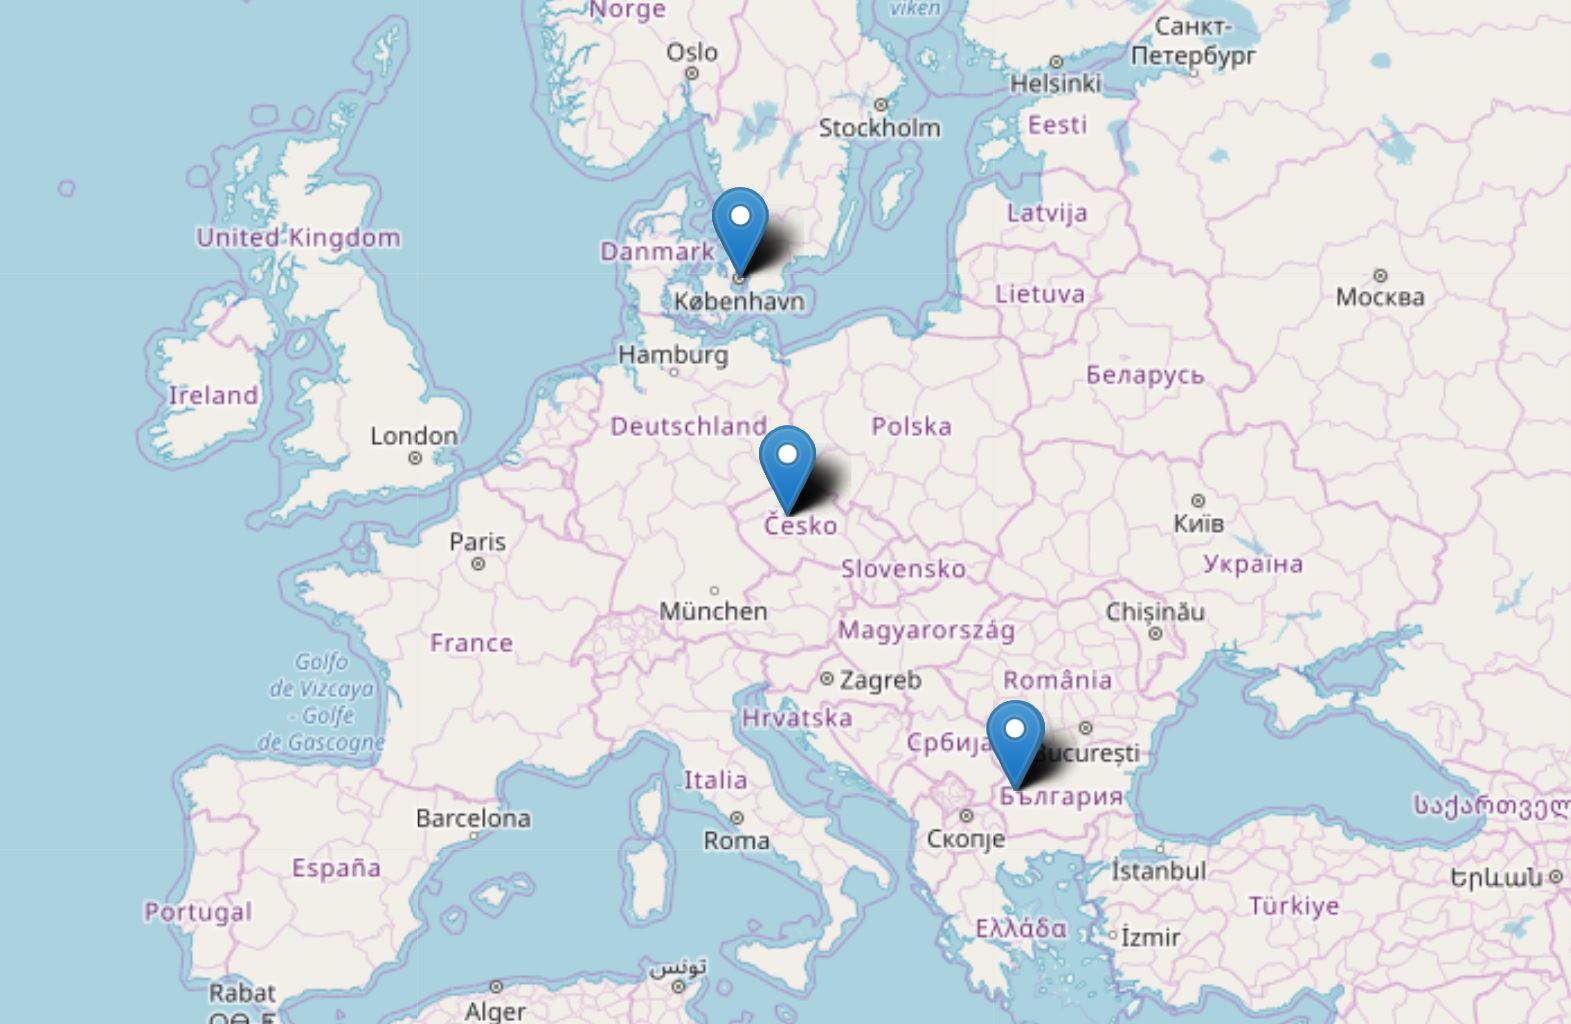

TOP 3 capitals zoomed in to Copenhagen:

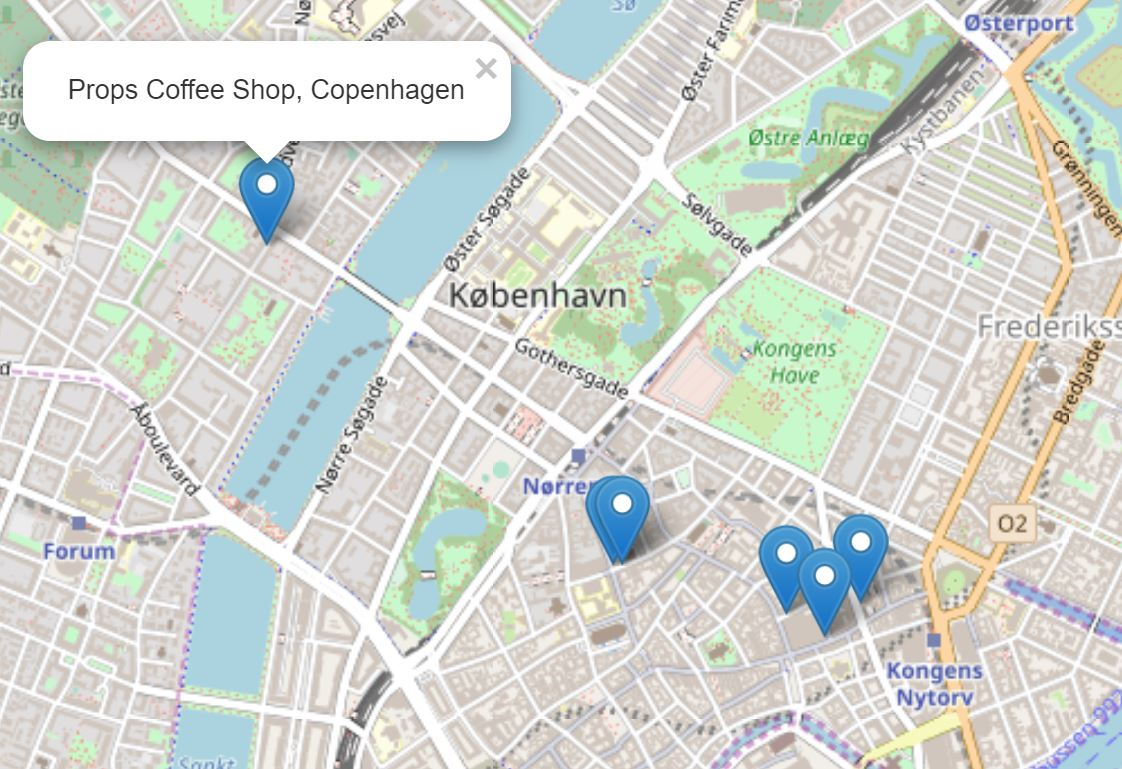

#### 2. TOP 10 Coffee Shops with the highest Rating

In [51]:
final_top_10_df = pd.DataFrame()

final_sorted_df=final_df.sort_values(['Rating'], ascending=False)
i=-1
for index, element in final_sorted_df.iterrows():
    i=i+1
    if (i<10): 
        final_top_10_df=final_top_10_df.append(element, ignore_index=True)

In [52]:
final_top_10_df

,Capital,Distance,Fri,ID,Latitude,Longitude,Mon,Name,Rating,Sat,Sun,Thu,Tue,Wed
0,Zagreb,373.0,7:00 PM,5504942a498e44f9c6c92202,45.811704,15.972729,6:00 PM,Cogito Coffee,9.3,6:00 PM,None,7:00 PM,7:00 PM,8:00 PM
1,Brussels,659.0,6:00 PM,57853eb6498e900c0a0be359,50.852100,4.348400,6:00 PM,Cafe Velvet Brussels,9.3,7:00 PM,6:00 PM,7:00 PM,6:00 PM,7:00 PM
2,Prague,895.0,8:00 PM,5664cf4d498e19a984df9678,50.079573,14.418838,7:00 PM,Super Tramp Coffee,9.2,None,5:00 PM,8:00 PM,8:00 PM,8:00 PM
3,Sofia,1360.0,7:00 PM,5617bc60498ec6b932e627a3,42.685748,23.324339,7:00 PM,Dabov specialty coffee,9.1,4:00 PM,None,7:00 PM,7:00 PM,8:00 PM
4,Vienna,1069.0,8:00 PM,5458cbab498ebedaabf75b65,48.214727,16.361707,9:00 AM,Jonas Reindl Coffee,9.0,8:00 PM,6:00 PM,8:00 PM,7:00 PM,7:00 PM
5,Nicosia,1016.0,6:00 PM,4f523f70e4b0ddd8f6ce3a6f,35.176170,33.363726,6:00 PM,Özerlat Turkish Coffee,9.0,7:00 PM,None,6:00 PM,7:00 PM,6:00 PM
6,Zagreb,1499.0,6:00 PM,4d7902d1c1d56ea81c3fd92b,45.816817,15.995661,Noon,Kim's Coffee,9.0,7:00 PM,3:00 PM,9:00 PM,9:00 PM,9:00 PM
7,Copenhagen,1071.0,5:00 PM,59a6d0f558002c501e82698c,55.680054,12.582381,6:00 PM,Coffee Collective,8.9,7:00 PM,6:00 PM,10:00 AM,1:00 PM,9:00 AM
8,Prague,1591.0,7:00 PM,4fab9efee4b03a9d6ad49052,50.073530,14.416270,8:00 PM,I Need Coffee!,8.9,5:00 PM,None,8:00 PM,7:00 PM,8:00 PM
9,Tallinn,901.0,8:00 PM,55589f1a498e86f0cebb5959,59.440546,24.730845,7:00 PM,Renard Coffee Shop,8.8,7:00 PM,7:00 PM,7:00 PM,7:00 PM,8:00 PM


In [53]:
address = 'Europe'
geolocator = Nominatim(user_agent="my-application")
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Downtown Toronto using latitude and longitude values
map_top_10 = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, capital, name, rating in zip(final_top_10_df['Latitude'], final_top_10_df['Longitude'], final_top_10_df['Capital'], final_top_10_df['Name'], final_top_10_df['Rating']):
    label = '{}, {}. Rating: {}'.format(name, capital, rating)
    label = folium.Popup(label, parse_html=True)
    
    folium.Marker([lat, lng], popup=label).add_to(map_top_10)
    
map_top_10

TOP 10 Coffee Shops:

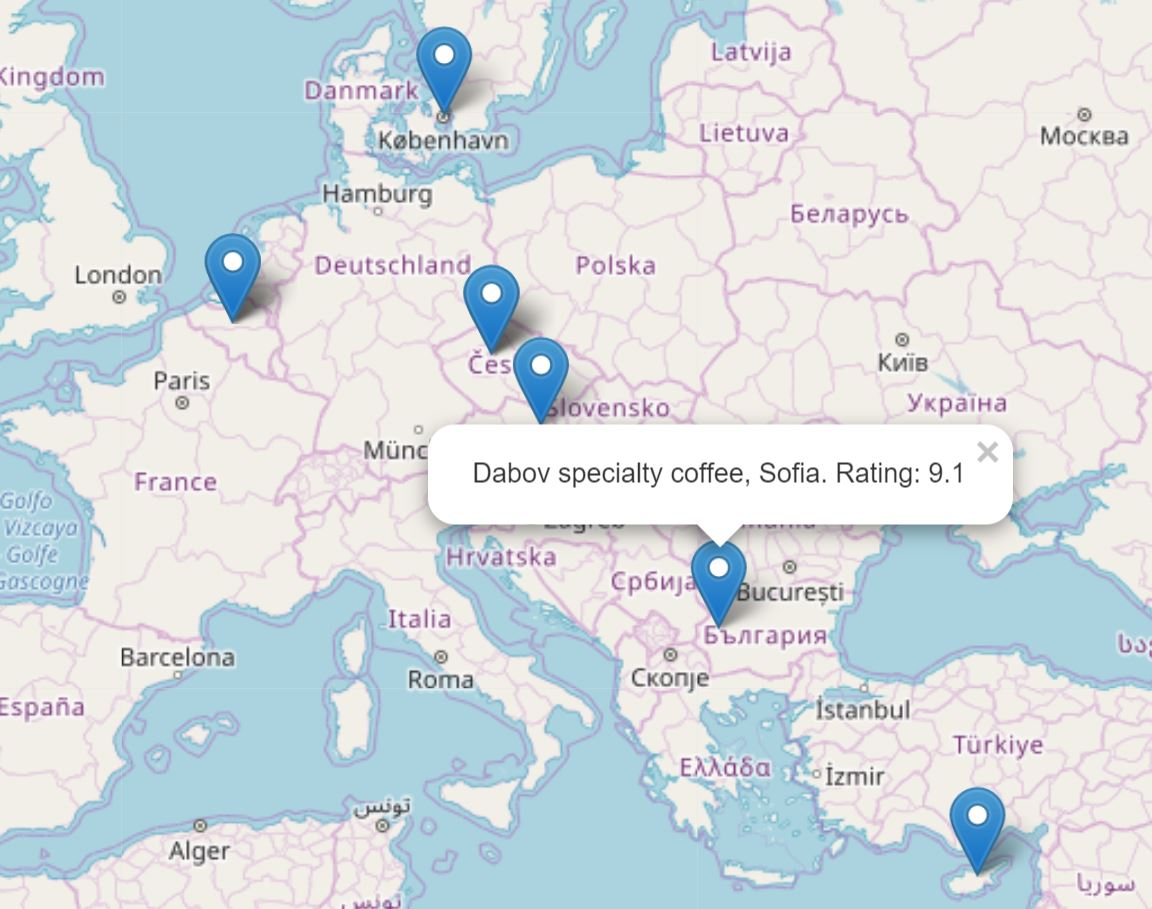

Preparing dataframe for clustering.

In [54]:
final_clustered_df = pd.DataFrame()
final_clustered_df=final_df

In [55]:
final_clustered_df=final_clustered_df.drop(['ID'], axis=1)
final_clustered_df=final_clustered_df.drop(['Latitude'], axis=1)
final_clustered_df=final_clustered_df.drop(['Longitude'], axis=1)
final_clustered_df=final_clustered_df.drop(['Name'], axis=1)
final_clustered_df=final_clustered_df.drop(['Capital'], axis=1)

*The following checks if the coffee shop is open or closed within certain hours.*

In [56]:
def check_elements(X):
    
    check = False
    
    if ('None' in X) or \
    ('8:00 AM' in X) or \
    ('9:00 AM' in X) or \
    ('10:00 AM' in X) or \
    ('11:00 AM' in X) or \
    ('Noon' in X) or \
    ('1:00 PM' in X) or \
    ('2:00 PM' in X) or \
    ('3:00 PM' in X) or \
    ('4:00 PM' in X) or \
    ('5:00 PM' in X) or \
    ('6:00 PM' in X): 
        check = True
    
    return check

The following is for normalizing data.

In [57]:
i=-1
for index, element in final_clustered_df.iterrows():
    i=i+1
    
    if (check_elements(element['Mon'])==True): final_clustered_df.at[i, 'Mon']=0
    else: final_clustered_df.at[i, 'Mon']=float(element['Mon'][0])/12
    
    if (check_elements(element['Tue'])==True): final_clustered_df.at[i, 'Tue']=0
    else: final_clustered_df.at[i, 'Tue']=float(element['Tue'][0])/12
        
    if (check_elements(element['Wed'])==True): final_clustered_df.at[i, 'Wed']=0
    else: final_clustered_df.at[i, 'Wed']=float(element['Wed'][0])/12
        
    if (check_elements(element['Thu'])==True): final_clustered_df.at[i, 'Thu']=0
    else: final_clustered_df.at[i, 'Thu']=float(element['Thu'][0])/12
        
    if (check_elements(element['Fri'])==True): final_clustered_df.at[i, 'Fri']=0
    else: final_clustered_df.at[i, 'Fri']=float(element['Fri'][0])/12
        
    if (check_elements(element['Sat'])==True): final_clustered_df.at[i, 'Sat']=0
    else: final_clustered_df.at[i, 'Sat']=float(element['Sat'][0])/12
        
    if (check_elements(element['Sun'])==True): final_clustered_df.at[i, 'Sun']=0
    else: final_clustered_df.at[i, 'Sun']=float(element['Sun'][0])/12
    
    final_clustered_df.at[i, 'Rating']=element['Rating']/10
    
    final_clustered_df.at[i, 'Distance']=1-(element['Distance']/2000)


In [58]:
final_clustered_df

,Distance,Fri,Mon,Rating,Sat,Sun,Thu,Tue,Wed
0,0.4655,0.666667,0,0.90,0.666667,0,0.666667,0.583333,0.583333
1,0.3195,0,0,0.84,0,0,0.583333,0,0
2,0.8235,0.583333,0.583333,0.81,0.583333,0.583333,0.583333,0.583333,0.583333
3,0.7690,0,0,0.81,0,0,0,0,0.583333
4,0.3390,0.583333,0.583333,0.81,0.583333,0.583333,0.583333,0.583333,0.583333
5,0.4225,0,0,0.83,0,0,0.583333,0.583333,0
6,0.3200,0.583333,0.583333,0.91,0,0,0.583333,0.583333,0.666667
7,0.0735,0,0,0.85,0.583333,0,0,0,0
8,0.7710,0.583333,0,0.82,0.583333,0.583333,0,0,0
9,0.3905,0.583333,0.583333,0.80,0.583333,0,0,0.583333,0.583333


Applying the kmeans algorithm.

In [59]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(final_clustered_df)

final_df['Group']=kmeans.labels_

final_df

,Distance,Fri,ID,Latitude,Longitude,Mon,Name,Rating,Sat,Sun,Thu,Tue,Wed,Capital,Group
0,1069.0,8:00 PM,5458cbab498ebedaabf75b65,48.214727,16.361707,9:00 AM,Jonas Reindl Coffee,9.0,8:00 PM,6:00 PM,8:00 PM,7:00 PM,7:00 PM,Vienna,0
1,1361.0,6:00 PM,4b6192b1f964a52049182ae3,48.197005,16.365656,3:00 PM,Blueorange - Coffee & Bagel,8.4,5:00 PM,6:00 PM,7:00 PM,6:00 PM,6:00 PM,Vienna,1
2,353.0,7:00 PM,4bb49954c4d8b7135d2d2b81,42.695170,23.324464,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM,Sofia,2
3,462.0,5:00 PM,50eea18ee4b0f01d157cf79d,42.700460,23.326590,6:00 PM,Barista Coffee And More,8.1,5:00 PM,5:00 PM,6:00 PM,5:00 PM,7:00 PM,Sofia,1
4,1322.0,7:00 PM,4bd6d3d2cfa7b7137e1628da,42.692578,23.336661,7:00 PM,Costa Coffee,8.1,7:00 PM,7:00 PM,7:00 PM,7:00 PM,7:00 PM,Sofia,2
5,1155.0,6:00 PM,568289a8498e28b919260245,42.698785,23.336241,9:00 AM,Barka coffee house,8.3,6:00 PM,9:00 AM,7:00 PM,7:00 PM,6:00 PM,Sofia,1
6,1360.0,7:00 PM,5617bc60498ec6b932e627a3,42.685748,23.324339,7:00 PM,Dabov specialty coffee,9.1,4:00 PM,None,7:00 PM,7:00 PM,8:00 PM,Sofia,2
7,1853.0,2:00 PM,59eb462231fd141cd48c7afa,42.693216,23.343929,4:00 PM,Percolate Coffee,8.5,7:00 PM,5:00 PM,3:00 PM,5:00 PM,2:00 PM,Sofia,1
8,458.0,7:00 PM,590eb5caf00a703cb85b9cdf,60.167938,24.950775,6:00 PM,Robert's Coffee Jugend,8.2,7:00 PM,7:00 PM,6:00 PM,2:00 PM,6:00 PM,Helsinki,1
9,1219.0,7:00 PM,5558c2f4498e46459173c7de,60.162808,24.922593,7:00 PM,Cargo Coffee + Vegetarian Food,8.0,7:00 PM,4:00 PM,6:00 PM,7:00 PM,7:00 PM,Helsinki,2


In [70]:
address = 'Europe'
geolocator = Nominatim(user_agent="my-application")
location = do_geocode(address)
latitude = location.latitude
longitude = location.longitude

color_array = ['blue', 'red', 'green']

# create map of Downtown Toronto using latitude and longitude values
map_grouped = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, capital, name, group, rating in zip(final_df['Latitude'], final_df['Longitude'], final_df['Capital'], final_df['Name'], final_df['Group'], final_df['Rating']):  
    html="""
        <div style="background: linear-gradient(#B9D9C3, #F1F1F2); border:5px solid {}; border-radius: 25px;">
        <p style="font-size:180%; line-height: 0.7;color:{}; padding-top: 15px; padding-right: 15px; padding-left: 15px"><b>{}</b></p>
        <p style="font-size:160%; text-align:center; line-height: 0.7;">Rating: {}</p>
        <p style="font-size:100%; line-height: 0.7; font-family:Comic Sans MS; padding-bottom: 15px; padding-left: 15px"><b>{}</b></p>
        </div>
        """.format(color_array[group], color_array[group], name, rating, capital)
    
    map_grouped.add_child(folium.Marker(
        location=[lat, lng],
        popup=folium.Popup(html, parse_html=True),
        icon=folium.Icon(color=color_array[group], icon='heart')))

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 350px; height: 140px; 
                            border:5px solid #283655; z-index:9999; font-size:14px;
                            background: linear-gradient(#B9D9C3, #F1F1F2); border-radius: 25px;
                            "><p text-align:center; line-height: 0.5;><b>&nbsp;&nbsp;&nbsp; LEGEND </b></p>
                              &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"> </i>&nbsp; Best hours, distance/rating similar to blue group<br>
                              &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"> </i>&nbsp; Furthest from the center but best ratings<br>
                              &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"> </i>&nbsp; Worst distance/hour/rating combo
                </div>
                ''' 

map_grouped.get_root().html.add_child(folium.Element(legend_html))
   
map_grouped

Coffee Chop clusters:

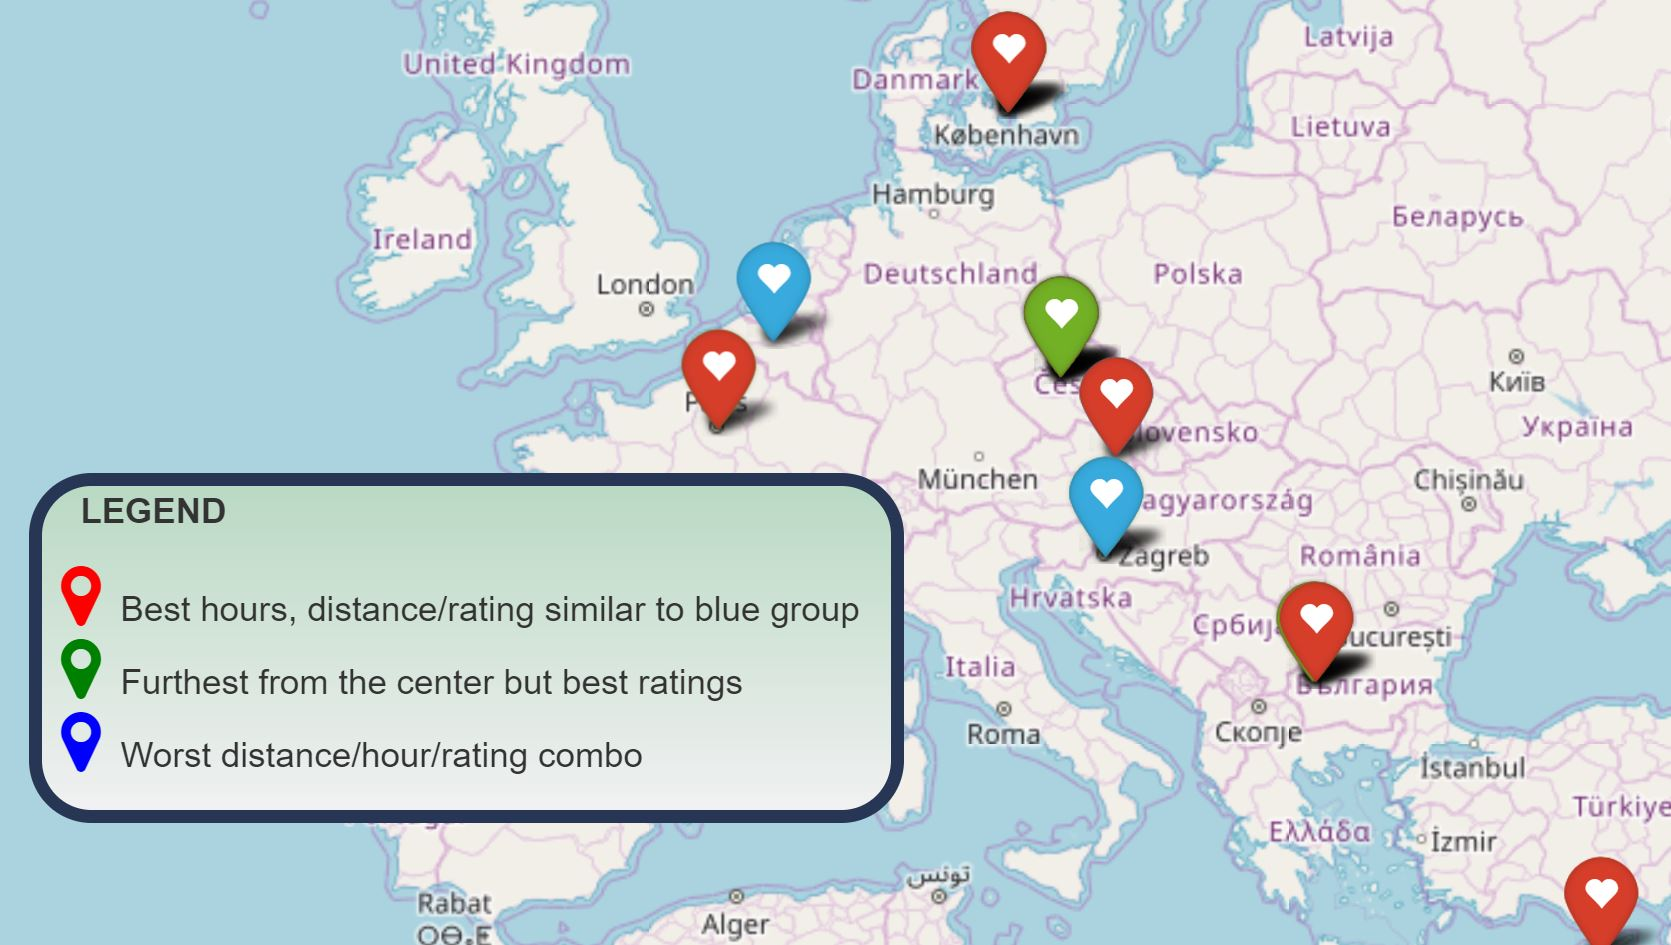

Coffee Shop clusters zoomed in to Copenhagen:

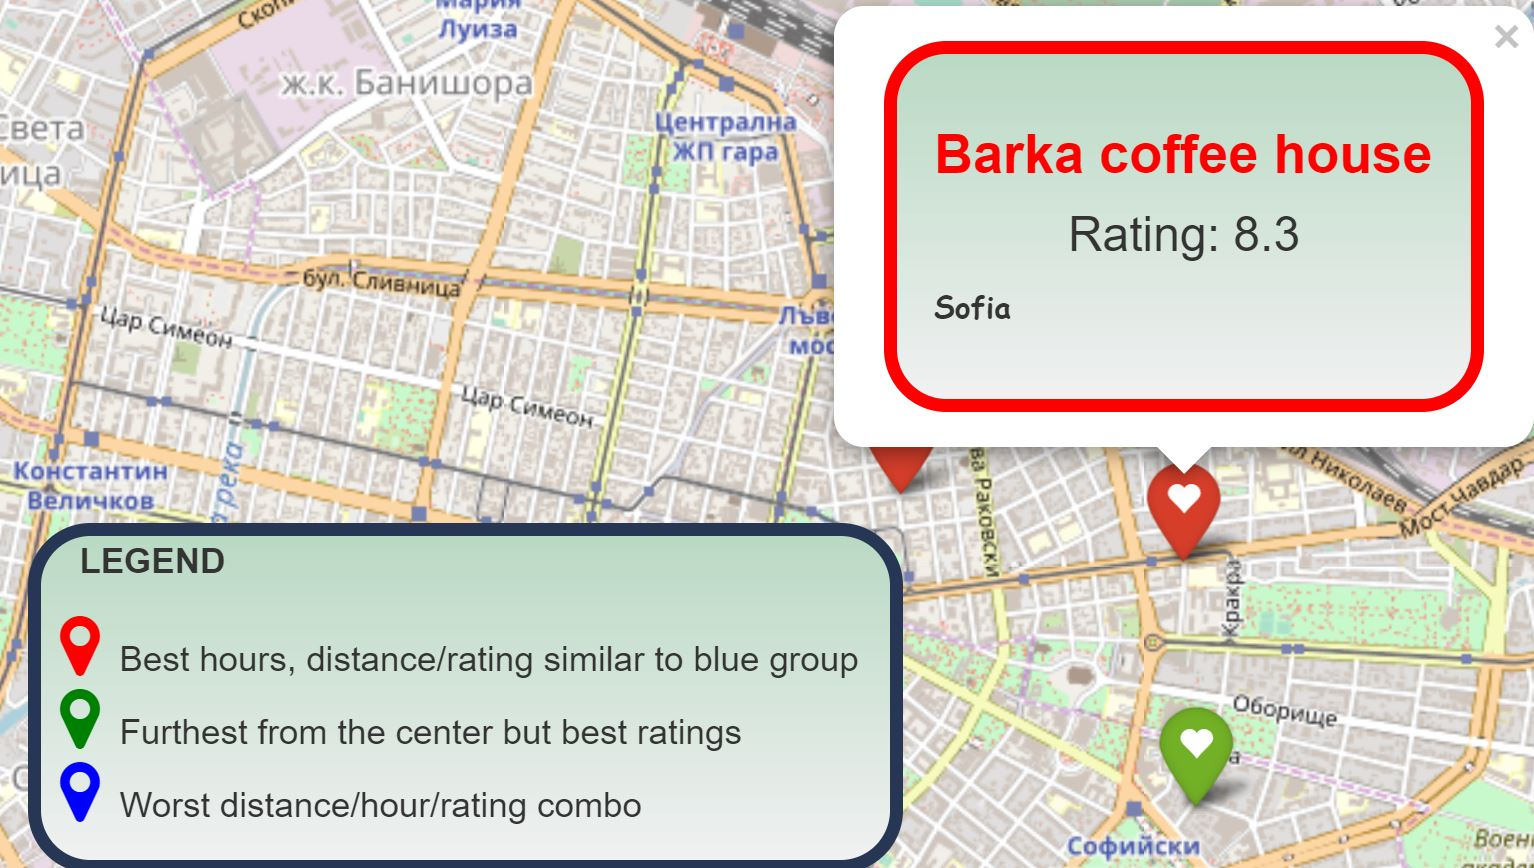